In [11]:
import glob
import torch
from torch.utils import data
from PIL import Image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

#通过创建data.Dataset子类Mydataset来创建输入
class Mydataset(data.Dataset):
# 类初始化
    def __init__(self, root):
        self.imgs_path = root
# 进行切片
    def __getitem__(self, index):
        img_path = self.imgs_path[index]
        return img_path
# 返回长度
    def __len__(self):
        return len(self.imgs_path)



120
120
['/home/lyc/doc/AML_LAB/img_data/True_7che.png', '/home/lyc/doc/AML_LAB/img_data/False_3carol.png', '/home/lyc/doc/AML_LAB/img_data/True_1che.png']
['/home/lyc/doc/AML_LAB/img_data/True_3xizhi.png', '/home/lyc/doc/AML_LAB/img_data/True_5zimo.png', '/home/lyc/doc/AML_LAB/img_data/True_10xizhi.png', '/home/lyc/doc/AML_LAB/img_data/False_3zimo.png', '/home/lyc/doc/AML_LAB/img_data/False_2zekai.png']
{'False': 0, 'True': 1}
{0: 'False', 1: 'True'}
torch.Size([10, 3, 240, 320])


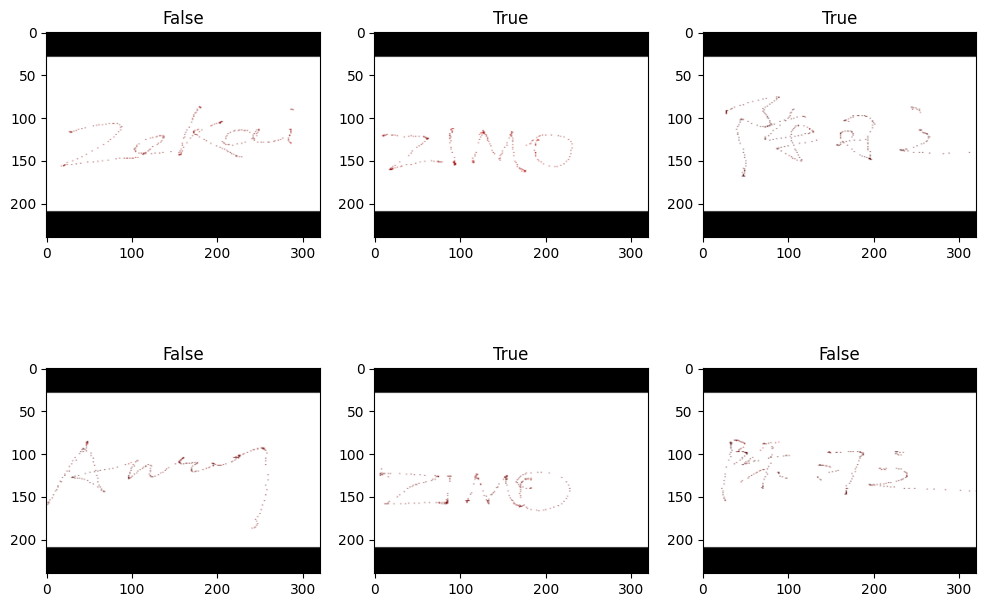

In [12]:
#使用glob方法来获取数据图片的所有路径
all_imgs_path = glob.glob(r'/home/lyc/doc/AML_LAB/img_data/*.png')#数据文件夹路径，根据实际情况更改！
#循环遍历输出列表中的每个元素，显示出每个图片的路径
sample_size=0
for var in all_imgs_path:
    sample_size+=1

print(sample_size)

#利用自定义类Mydataset创建对象weather_dataset
signature_dataset = Mydataset(all_imgs_path)
print(len(signature_dataset)) #返回文件夹中图片总个数
sinature_datalodaer = torch.utils.data.DataLoader(signature_dataset, batch_size=5) #每次迭代时返回五个数据
print(next(iter(sinature_datalodaer)))

species = ['False','True']
species_to_id = dict((c, i) for i, c in enumerate(species))
print(species_to_id)
id_to_species = dict((v, k) for k, v in species_to_id.items())
print(id_to_species)
all_labels = []
#对所有图片路径进行迭代
for img in all_imgs_path:
    # 区分出每个img，应该属于什么类别
    for i, c in enumerate(species):
        if c in img:
            all_labels.append(i)
#print(all_labels) #得到所有标签
            

            
# 对数据进行转换处理
transform = transforms.Compose([
                transforms.Resize((240,320)), #做的第一步转换
                transforms.ToTensor() #第二步转换，作用：第一转换成Tensor，第二将图片取值范围转换成0-1之间，第三会将channel置前
])

class Mydatasetpro(data.Dataset):
# 类初始化
    def __init__(self, img_paths, labels, transform):
        self.imgs = img_paths
        self.labels = labels
        self.transforms = transform
# 进行切片
    def __getitem__(self, index):                #根据给出的索引进行切片，并对其进行数据处理转换成Tensor，返回成Tensor
        img = self.imgs[index]
        label = self.labels[index]
        pil_img = Image.open(img)                 #pip install pillow
        data = self.transforms(pil_img)
        return data, label
# 返回长度
    def __len__(self):
        return len(self.imgs)



BATCH_SIZE = 10
signature_dataset = Mydatasetpro(all_imgs_path, all_labels, transform)
sinature_datalodaer = data.DataLoader(
                            signature_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True
)

imgs_batch, labels_batch = next(iter(sinature_datalodaer))
print(imgs_batch.shape)

plt.figure(figsize=(12, 8))
for i, (img, label) in enumerate(zip(imgs_batch[:6], labels_batch[:6])):
    img = img.permute(1, 2, 0).numpy()
    plt.subplot(2, 3, i+1)
    plt.title(id_to_species.get(label.item()))
    plt.imshow(img)
plt.show()#展示图片


In [13]:
import pandas as pd 

#划分测试集和训练集
index = np.random.permutation(len(all_imgs_path))

all_imgs_path = np.array(all_imgs_path)[index]
all_labels = np.array(all_labels)[index]

#80% as train
s = int(len(all_imgs_path)*0.7)
print(s)

train_imgs = all_imgs_path[:s]
train_labels = all_labels[:s]
test_imgs = all_imgs_path[s:]
test_labels = all_labels[s:]





print(test_labels)
train_ds = Mydatasetpro(train_imgs, train_labels, transform) #TrainSet TensorData
test_ds = Mydatasetpro(test_imgs, test_labels, transform) #TestSet TensorData

print(train_ds)
train_imgs = pd.get_dummies(train_imgs)
test_imgs = pd.get_dummies(test_imgs)
#print(train_ds)

train_dl = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)#TrainSet Labels
test_dl = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)#TestSet Labels






84
[0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1 1 1]


## 训练

## Resnet

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torchvision import models
from torchsummary import summary
# 假设您的数据集已经准备好，包括训练集和验证集
# 这里仅作示例，您需要根据实际情况修改数据加载部分




# 初始化ResNet模型
model_resnet = resnet18(pretrained=True)
num_classes = 2
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)




# 设置优化器和损失函数
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet.to(device)

for epoch in range(30):  # 假设训练30个epoch
    model_resnet.train()
    running_loss = 0.0
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)  # 将图像和标签分别移动到设备上
        optimizer.zero_grad()
        outputs = model_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/30], Loss: {running_loss / len(train_dl)}")



summary(model_resnet, input_size=(3,256,256), batch_size=-1, device='cuda')
# 验证模型


model_resnet.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)  # 将图像和标签分别移动到设备上
        outputs = model_resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")


/home/lyc/anaconda3/envs/mix/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lyc/anaconda3/envs/mix/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Loss: 1.0090381569332547
Epoch [2/30], Loss: 0.7230524023373922
Epoch [3/30], Loss: 0.7109478248490227
Epoch [4/30], Loss: 0.654264317618476
Epoch [5/30], Loss: 0.6133258740107218
Epoch [6/30], Loss: 0.46394144164191353
Epoch [7/30], Loss: 0.3706771234671275
Epoch [8/30], Loss: 0.5773326489660475
Epoch [9/30], Loss: 0.5419111450513204
Epoch [10/30], Loss: 0.35536521259281373
Epoch [11/30], Loss: 0.12175898605750667
Epoch [12/30], Loss: 0.10916389317976104
Epoch [13/30], Loss: 0.26119733332759804
Epoch [14/30], Loss: 0.16208734011484516
Epoch [15/30], Loss: 0.11516961962398556
Epoch [16/30], Loss: 0.2644244501781132
Epoch [17/30], Loss: 0.14224936895900303
Epoch [18/30], Loss: 0.10063927460254894
Epoch [19/30], Loss: 0.03320616949349642
Epoch [20/30], Loss: 0.049652176081306405
Epoch [21/30], Loss: 0.06875603788325356
Epoch [22/30], Loss: 0.31274635520660216
Epoch [23/30], Loss: 0.08486159207920234
Epoch [24/30], Loss: 0.2140337350881762
Epoch [25/30], Loss: 0.159098345372

## VGG16

In [15]:
from torchvision.models import vgg16  # 更改这里导入VGG模型

model_vgg = vgg16(pretrained=True)
num_classes = 2
# VGG的分类器是一个Sequential模块，最后一层是一个全连接层
model_vgg.classifier[6] = nn.Linear(model_vgg.classifier[6].in_features, num_classes)  # 修改VGG最后的全连接层

# 设置优化器和损失函数
optimizer = optim.Adam(model_vgg.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_vgg.to(device)

for epoch in range(30):  # 假设训练30个epoch
    model_vgg.train()
    running_loss = 0.0
    for images, labels in train_dl:  # 确保train_dl是你的训练数据加载器
        images, labels = images.to(device), labels.to(device)  # 将图像和标签分别移动到设备上
        optimizer.zero_grad()
        outputs = model_vgg(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/30], Loss: {running_loss / len(train_dl)}")

# 模型摘要
summary(model_vgg, input_size=(3, 256, 256), batch_size=-1, device='cuda')

# 验证模型
model_vgg.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dl:  # 确保test_dl是你的测试数据加载器
        images, labels = images.to(device), labels.to(device)
        outputs = model_vgg(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

/home/lyc/anaconda3/envs/mix/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Loss: 2.6391138633092246
Epoch [2/30], Loss: 0.891069213549296
Epoch [3/30], Loss: 0.7654379142655267
Epoch [4/30], Loss: 0.7207072377204895
Epoch [5/30], Loss: 0.7083407640457153
Epoch [6/30], Loss: 0.712694976064894
Epoch [7/30], Loss: 0.7121826410293579
Epoch [8/30], Loss: 0.7519542177518209
Epoch [9/30], Loss: 0.7052815357844034
Epoch [10/30], Loss: 0.7203893926408556
Epoch [11/30], Loss: 0.7031756242116293
Epoch [12/30], Loss: 0.7284228006998698
Epoch [13/30], Loss: 0.7149966557820638
Epoch [14/30], Loss: 0.6840972635481093
Epoch [15/30], Loss: 0.7235415710343255
Epoch [16/30], Loss: 0.698410153388977
Epoch [17/30], Loss: 0.7178771562046475
Epoch [18/30], Loss: 0.7426761918597751
Epoch [19/30], Loss: 0.7120083769162496
Epoch [20/30], Loss: 0.7083044714397855
Epoch [21/30], Loss: 0.71602996190389
Epoch [22/30], Loss: 0.7191889219813876
Epoch [23/30], Loss: 0.6993148591783311
Epoch [24/30], Loss: 0.7041522926754422
Epoch [25/30], Loss: 0.7219625578986274
Epoch [26/30],

In [16]:
from torchvision import models

model_alex = models.alexnet(pretrained=True)
num_classes = 2
# VGG的分类器是一个Sequential模块，最后一层是一个全连接层
model_alex.classifier[6] = nn.Linear(model_alex.classifier[6].in_features, num_classes)  # 修改VGG最后的全连接层

# 设置优化器和损失函数
optimizer = optim.Adam(model_alex.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_alex.to(device)

for epoch in range(30):  # 假设训练30个epoch
    model_alex.train()
    running_loss = 0.0
    for images, labels in train_dl:  # 确保train_dl是你的训练数据加载器
        images, labels = images.to(device), labels.to(device)  # 将图像和标签分别移动到设备上
        optimizer.zero_grad()
        outputs = model_alex(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/30], Loss: {running_loss / len(train_dl)}")

# 模型摘要
summary(model_alex, input_size=(3, 256, 256), batch_size=-1, device='cuda')

# 验证模型
model_alex.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dl:  # 确保test_dl是你的测试数据加载器
        images, labels = images.to(device), labels.to(device)
        outputs = model_alex(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

/home/lyc/anaconda3/envs/mix/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Loss: 1.4038848612043593
Epoch [2/30], Loss: 0.7591035895877414
Epoch [3/30], Loss: 0.7420987486839294
Epoch [4/30], Loss: 0.7311559187041389
Epoch [5/30], Loss: 0.7044460442331102
Epoch [6/30], Loss: 0.694562104013231
Epoch [7/30], Loss: 0.6942099200354682
Epoch [8/30], Loss: 0.7040364411142137
Epoch [9/30], Loss: 0.6916324098904928
Epoch [10/30], Loss: 0.6926915844281515
Epoch [11/30], Loss: 0.6957953969637553
Epoch [12/30], Loss: 0.6935693091816373
Epoch [13/30], Loss: 0.6965023875236511
Epoch [14/30], Loss: 0.6944934791988797
Epoch [15/30], Loss: 0.6955071025424533
Epoch [16/30], Loss: 0.6933433810869852
Epoch [17/30], Loss: 0.6964102188746134
Epoch [18/30], Loss: 0.6930805179807875
Epoch [19/30], Loss: 0.698450591829088
Epoch [20/30], Loss: 0.6959928870201111
Epoch [21/30], Loss: 0.6923771036995782
Epoch [22/30], Loss: 0.6975167857276069
Epoch [23/30], Loss: 0.6984588106473287
Epoch [24/30], Loss: 0.6945530308617486
Epoch [25/30], Loss: 0.6987551119592454
Epoch [26/3